<a href="https://colab.research.google.com/github/SongAddict/BrainCracker/blob/main/%EC%8B%9C%EA%B3%84%EC%97%B4_%EC%B1%85_TFT_%EC%8B%A4%EC%8A%B5ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리(p355)

In [ ]:
!pip install darts

In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

# Example of using an alternative to plot_act
from statsmodels.graphics.tsaplots import plot_acf

# Your code here

# 데이터 불러오기(p355~p357)

In [ ]:
num_samples = 200
figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99

# Corrected string formatting
label_q_outer = f'{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles'
label_q_inner = f'{int(low_q * 100)}-{int(high_q * 100)}th percentiles'

print(label_q_outer)
print(label_q_inner)

1-99th percentiles
10-90th percentiles


In [ ]:
# Load the AirPassengers dataset
series = AirPassengersDataset().load()

# Normalize the series by the number of days in each month
series = series / TimeSeries.from_series(series.time_index.days_in_month)
series = series.astype(np.float32)

# Split the series into training and validation sets
training_cutoff = pd.Timestamp("19571201")
train, val = series.split_after(training_cutoff)

# Scale the series
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# Create covariates
covariates = datetime_attribute_timeseries(series, attribute='year', one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(series, attribute='month', one_hot=False))
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=series.time_index,
        values=np.arange(len(series)),
        columns=['linear_increase'])  # Corrected column name
)
covariates = covariates.astype(np.float32)  # Corrected typo: np.lloat32 -> np.float32

# Scale the covariates
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)



# 모델 정의 및 훈련(p357~359)

In [ ]:
quantiles = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
input_chunk_length = 24
forecast_horizon = 12

# 모델 정의 (원본 설정 유지)
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(quantiles=quantiles),
    random_state=42
)

# 모델 학습
my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 7.0 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


TFTModel(output_chunk_shift=0, hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[list[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=24, output_chunk_length=12, batch_size=16, n_epochs=300, add_encoders=None, random_state=42)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

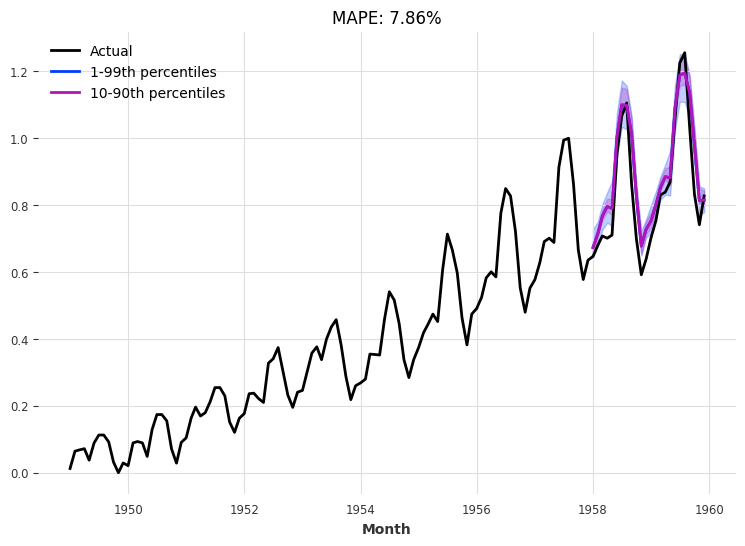

In [ ]:

def eval_model(model, n, actual_series, val_series):
    # 예측 및 정렬
    pred_series = model.predict(n=n, num_samples=num_samples)

    # 시각화
    plt.figure(figsize=figsize)
    actual_series[:pred_series.end_time()].plot(label='Actual')
    pred_series.plot(low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer)
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    # 성능 평가
    mape_value = mape(val_series.slice_intersect(pred_series), pred_series)
    plt.title(f'MAPE: {mape_value:.2f}%')
    plt.legend()

# 사용 예시 (output_chunk_length=24로 모델 재정의 후)
eval_model(
    my_model,
    n=24,
    actual_series=series_transformed,
    val_series=val_transformed
)

In [ ]:
backtest_series = my_model.historical_forecasts(series_transformed,
    future_covariates=covariates_transformed,
    start=train.end_time() + train.freq, num_samples = num_samples,  # 마지막 훈련 지점 다음부터 시작
    forecast_horizon=forecast_horizon,stride=forecast_horizon,  # 예측 간격 = forecast_horizon
    last_points_only=False,   # 모든 예측 구간 유지
    retrain=False,
    verbose=True  # 오타 수정 (True.)
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

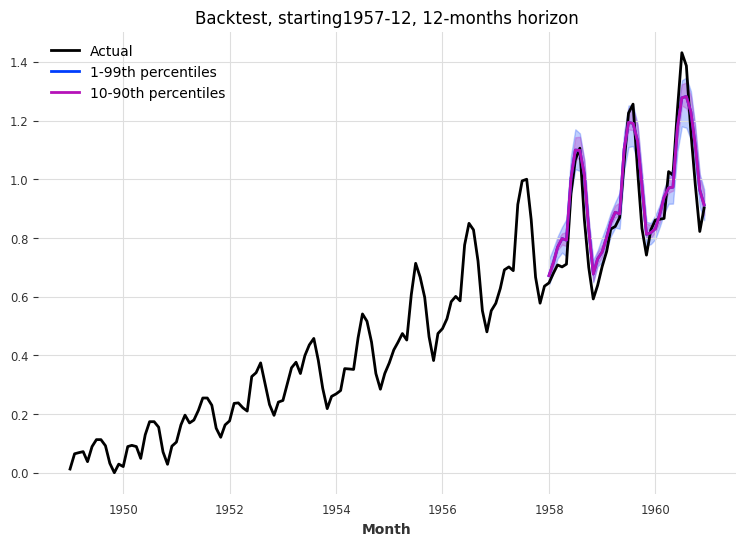

MAPE: 5.59%


In [ ]:
def eval_backtest(backtest_series, actual_series, horizon, start, transformer):

    # 시각화
    plt.figure(figsize=figsize)
    actual_series.plot(label="Actual")
    backtest_series.plot(low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer)
    backtest_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)
    plt.legend()
    plt.title(f"Backtest, starting{start}, {horizon}-months horizon")
    plt.show()
    print("MAPE: {:.2f}%".format(
        mape(transformer.inverse_transform(actual_series),
             transformer.inverse_transform(backtest_series))))

# 사용 예시 (함수 외부에서 독립적으로 호출)
eval_backtest(
    backtest_series=concatenate(backtest_series),  # darts의 concatenate 메서드 사용
    actual_series=series_transformed,
    horizon=forecast_horizon,
    start=training_cutoff.strftime("%Y-%m"),  # datetime -> 문자열 포맷팅
    transformer=transformer
)

# 다른 데이터를 적용(p360~)

(True, 12)
(True, 12)


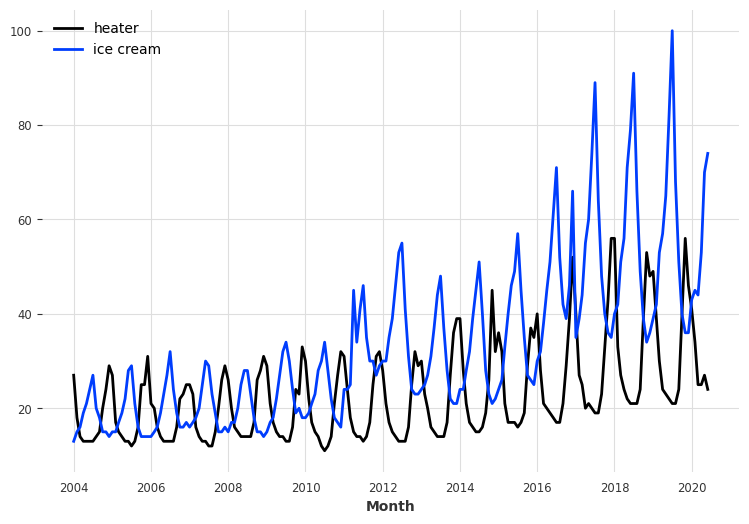

In [ ]:
series_ice_heater = IceCreamHeaterDataset().load()
plt.figure(figsize=figsize)
series_ice_heater.plot()
print(check_seasonality(series_ice_heater["ice cream"], max_lag=36))
print(check_seasonality(series_ice_heater["heater"], max_lag=36))

In [ ]:
converted_series = []
for col in ["ice cream", "heater"]:
    converted_series.append(series_ice_heater[col] /
                            TimeSeries.from_series(series_ice_heater.time_index.days_in_month))

converted_series = concatenate(converted_series, axis=1)
converted_series = converted_series[pd.Timestamp("20100101"):]

forecast_horizon_ice = 12
training_cutoff_ice = converted_series.time_index[-(2 * forecast_horizon_ice)]

series_ice = converted_series["ice cream"]
train_ice, val_ice = series_ice.split_before(training_cutoff_ice)
transformer_ice = Scaler()
train_ice_transformed = transformer_ice.fit_transform(train_ice)
val_ice_transformed = transformer_ice.transform(val_ice)
series_ice_transformed = transformer_ice.transform(series_ice)

covariates_heat = converted_series["heater"]
cov_heat_train, cov_heat_val = covariates_heat.split_before(training_cutoff_ice)
transformer_heat = Scaler()
transformer_heat.fit(cov_heat_train)
covariates_heat_transformed = transformer_heat.transform(covariates_heat)


In [ ]:
input_chunk_length_ice = 36
my_model_ice = TFTModel(input_chunk_length=input_chunk_length_ice,
                        output_chunk_length=forecast_horizon_ice, hidden_size=32, lstm_layers=1,
                        batch_size=16, n_epochs=300, dropout=0.1,
                        add_encoders={"cyclic": {"future": ["month"]}},
                        add_relative_index=False, optimizer_kwargs={"lr": 1e-3},
                        random_state=42)

my_model_ice.fit(
    train_ice_transformed, past_covariates=covariates_heat_transformed, verbose=True
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 3.9 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


TFTModel(output_chunk_shift=0, hidden_size=32, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=36, output_chunk_length=12, batch_size=16, n_epochs=300, add_encoders={'cyclic': {'future': ['month']}}, optimizer_kwargs={'lr': 0.001}, random_state=42)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

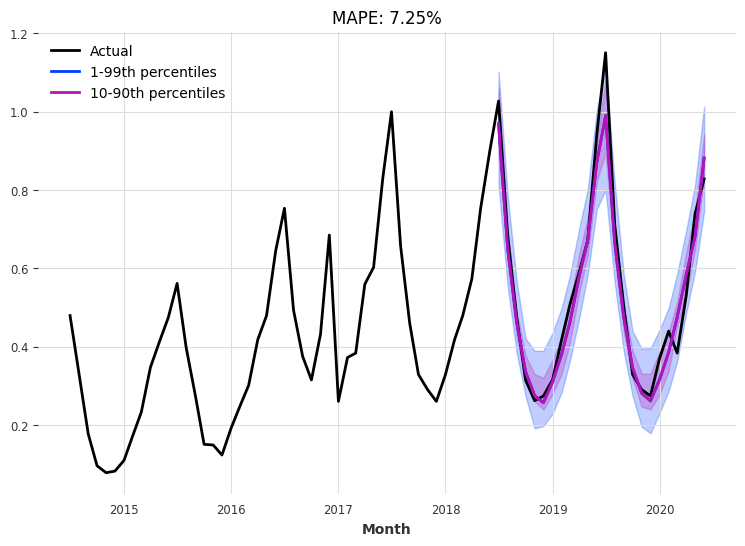

In [ ]:
n = 24  # 평가 구간 길이 설정 (예: 24시간/24일 단위)

# 모델 평가 실행
eval_model(
    model=my_model_ice,  # 평가 대상 모델
    n=n,                 # 평가 구간 길이

    # 실제 값 시계열: 학습 데이터 끝에서 (2n-1) 주기만큼 이전부터 1단계 간격으로 슬라이싱
    actual_series=series_ice_transformed[train_ice.end_time() - (2 * n - 1) * train_ice.freq : ] ,
    val_series=val_ice_transformed

    # 검증 데이터 시계열 (함수 호출 결과 또는 변수 전달)
    # 함수인 경우 () 추가 필요, 변수면 그대로 유지
)

In [ ]:
# 백테스트 설정: 각 예측 구간의 모든 포인트 저장 (마지막 포인트만 저장하려면 True로 변경)
last_points_only = False

# 모델을 사용하여 과거 시점부터 예측 수행
backtest_series_ice = my_model_ice.historical_forecasts(
    # 입력 데이터
    series_ice_transformed,           # 전처리 완료된 시계열 데이터

    # 예측 설정
    num_samples=num_samples,          # 확률적 예측 시뮬레이션 횟수 (불확실성 추정)
    start=training_cutoff_ice,        # 백테스트 시작 시점 (학습 데이터 종료 지점)
    forecast_horizon=forecast_horizon_ice,  # 단일 예측 구간 길이 (예: 7일 앞 예측)

    # 창 이동 설정
    stride=forecast_horizon_ice,      # 예측 창 이동 간격 (전체 예측 길이만큼 점프)
    overlap_end=True,                 # 시계열 끝부분 부분적 중복 허용

    # 모델 동작 설정
    retrain=False,                    # 모델 재학습 없이 고정 가중치 사용
    last_points_only=last_points_only,# 모든 예측 포인트 저장 여부

    # 기타
    verbose=True,                     # 진행률 출력 활성화
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

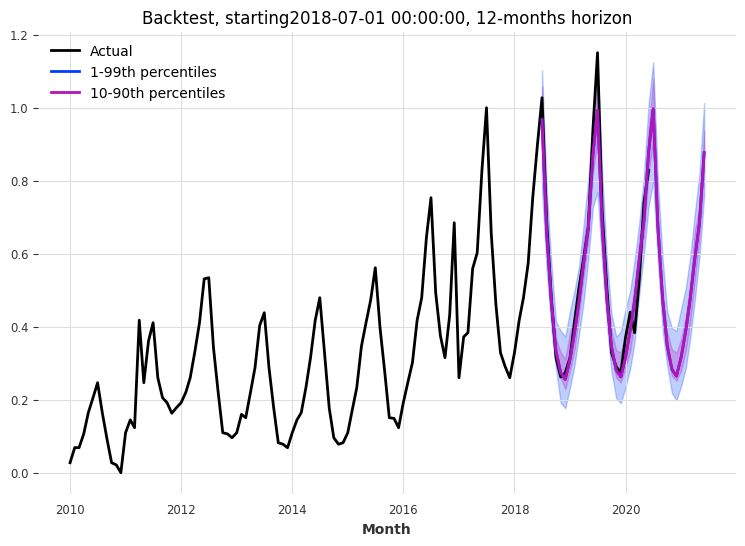

MAPE: 4.75%


In [ ]:
backtest_series_ice = (
    concatenate(backtest_series_ice)  # 리스트인 경우 연결(concat)
    if isinstance(backtest_series_ice, list)
    else backtest_series_ice)

eval_backtest(
    backtest_series=backtest_series_ice,
    actual_series=series_ice_transformed[
        train_ice.start_time() - 2 * forecast_horizon_ice * train_ice.freq :  # 슬라이싱
    ],
    horizon=forecast_horizon_ice,
    start=training_cutoff_ice,
    transformer=transformer_ice)

# 불변 공변량을 추가(p363~)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries

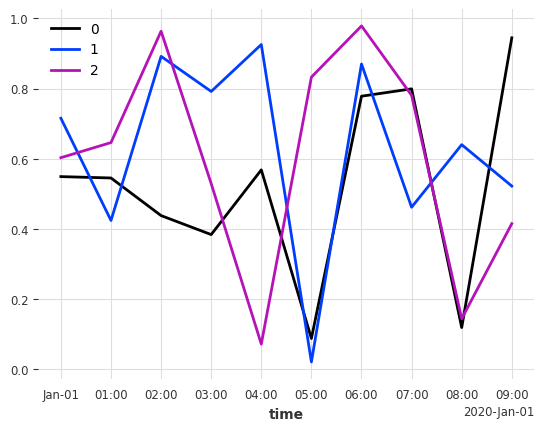

In [ ]:
np.random.seed(0)
series = TimeSeries.from_times_and_values(
    times=pd.date_range(start="2020-01-01", periods=10, freq="h"),
    values=np.random.rand(10, 3)
)
series.plot()
plt.show()

In [ ]:
static_covs_single = pd.DataFrame(data={'cont': [0], 'cat': ['a']})
print(static_covs_single)
static_covs_multi = pd.DataFrame(data={'cont': [0, 2, 1], 'cat': ['e', 'c', 'b']})
print(static_covs_multi)

   cont cat
0     0   a
   cont cat
0     0   e
1     2   c
2     1   b


In [ ]:
series_single = series.with_static_covariates(static_covs_single)
print("Single row static covaries with multivariate 'series")
print(series_single.static_covariates)

series_multi = series.with_static_covariates(static_covs_multi)
print("\nNulli row static covaries with multivariate 'series")
print(series_rnulli.static_covariates)

Single row static covaries with multivariate 'series
static_covariates  cont cat
global_components   0.0   a

Nulli row static covaries with multivariate 'series
static_covariates  cont cat
component                  
0                   0.0   e
1                   2.0   c
2                   1.0   b


In [ ]:
from darts.dataprocessing.transformers import StaticCovariatesTransformer
transformer = StaticCovariatesTransformer()
series_transformed = transformer.fit_transform(series_multi)
for i, (ts, ts_scaled) in enumerate(zip(series_multi, series_transformed)):
    print(f"Original series [i]")
    print(ts.static_covariates)
    print(f'Transformed series [i]')
    print(ts_scaled.static_covariates)
    print("")

Original series [i]
static_covariates  cont cat
component                  
0                   0.0   e
1                   2.0   c
2                   1.0   b
Transformed series [i]
static_covariates  cont  cat
component                   
0                   0.0  2.0
1                   1.0  1.0
2                   0.5  0.0

Original series [i]
static_covariates  cont cat
component                  
0                   0.0   e
1                   2.0   c
2                   1.0   b
Transformed series [i]
static_covariates  cont  cat
component                   
0                   0.0  2.0
1                   1.0  1.0
2                   0.5  0.0

Original series [i]
static_covariates  cont cat
component                  
0                   0.0   e
1                   2.0   c
2                   1.0   b
Transformed series [i]
static_covariates  cont  cat
component                   
0                   0.0  2.0
1                   1.0  1.0
2                   0.5  0.0

Original seri

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import TFTModel
from darts.utils import timeseries_generation as tg
from darts.dataprocessing.transformers import StaticCovariatesTransformer
from darts.metrics import mse

component              smooth
time                         
2000-01-01 00:00:00  0.000000
2000-01-01 01:00:00  0.309017
2000-01-01 02:00:00  0.587785
2000-01-01 03:00:00  0.809017
2000-01-01 04:00:00  0.951057
...                       ...
2000-01-04 03:00:00 -1.000000
2000-01-04 04:00:00 -0.951057
2000-01-04 05:00:00 -0.809017
2000-01-04 06:00:00 -0.587785
2000-01-04 07:00:00 -0.309017

[80 rows x 1 columns]


<Axes: xlabel='time'>

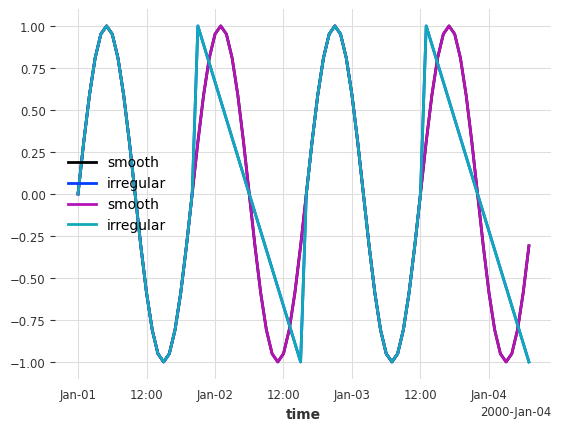

In [ ]:
period = 20
sine_series = tg.sine_timeseries(
    length=4 * period, value_frequency=1 / period, column_name='smooth', freq='h')
print(sine_series.pd_dataframe())
sine_vals = sine_series.values()
linear_vals = np.expand_dims(np.linspace(1, -1, num=19), -1)
sine_vals[21:40] = linear_vals
sine_vals[61:80] = linear_vals
irregular_series = TimeSeries.from_times_and_values(
    values=sine_vals, times=sine_series.time_index, columns=['irregular'])
sine_series.plot()
irregular_series.plot()
linear_vals = np.expand_dims(np.linspace(1, -1, num=19), -1)
sine_vals[21:40] = linear_vals
sine_vals[61:80] = linear_vals
irregular_series = TimeSeries.from_times_and_values(
    values=sine_vals, times=sine_series.time_index, columns=['irregular'])
sine_series.plot()
irregular_series.plot()

In [ ]:
def test_case(model, train_series, predict_series):
    model.fit(train_series)
    preds = model.predict(n=int(period / 2), num_samples=250, series=predict_series)
    for ts, ps in zip(train_series, preds):
        ts.plot()
        ps.plot()
        plt.show()
    return preds #Fixed return statement
def get_model_params():
    return {"input_chunk_length": int(period / 2),"output_chunk_length": int(period / 2),
    "add_encoders": {"datetime_attribute": {"future" : ["hour"]}},
    "random_state": 42,
    "n_epochs": 150}

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.2 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

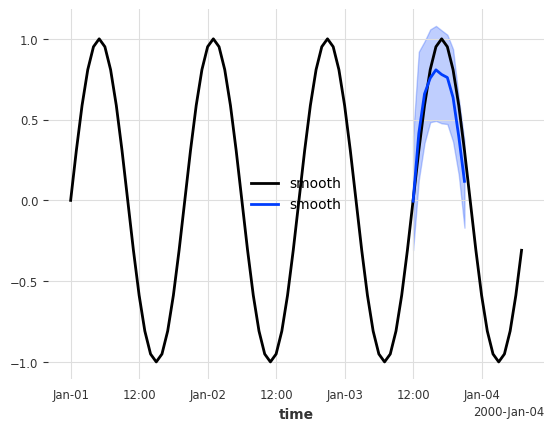

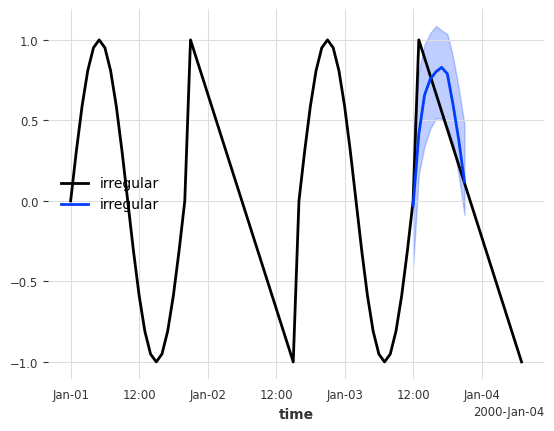

In [ ]:
train_series = [sine_series, irregular_series]
for series in train_series:
    assert not series.has_static_covariates
model = TFTModel(**get_model_params())
preds = test_case(model, train_series,
    predict_series=[series[:60] for series in train_series])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | future_cov_projection | _ResidualBlock   | 780    | train
6 | encoders              | Sequential       | 39.8 K | train
7 | decoders              | Sequential       | 99.1 K | train
8 | temporal_decoder      | _ResidualBlock   | 1.3 K  | train
9 | lookback_skip       

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

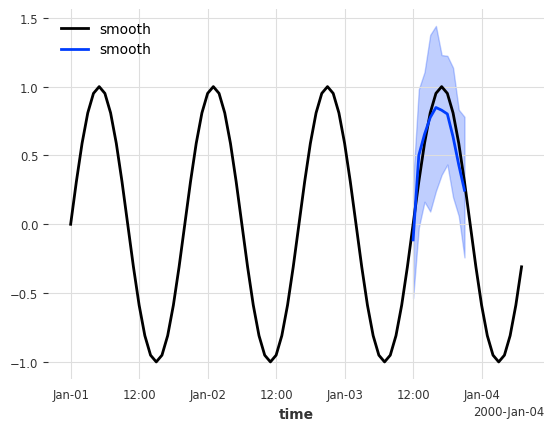

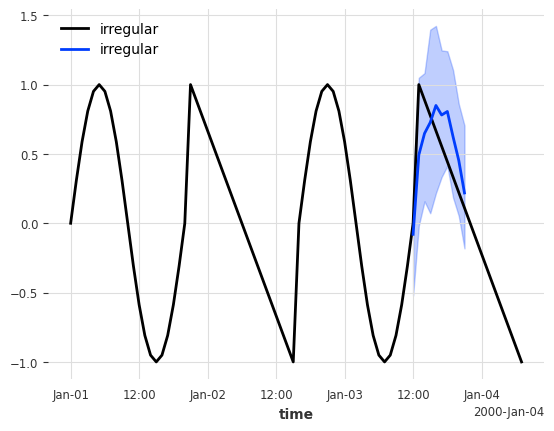

In [ ]:
from darts.models import TiDEModel
from darts.utils.likelihood_models import GaussianLikelihood
model = TiDEModel(**get_model_params(), likelihood=GaussianLikelihood())
preds = test_case(model, train_series,
    predict_series=[series[:60] for series in train_series])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 528    | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.2 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork   

static_covariates  Curve_type
component                    
smooth                    1.0
static_covariates  Curve_type
component                    
irregular                 0.0


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

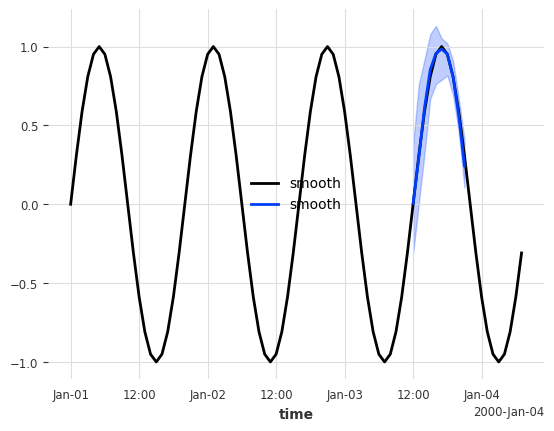

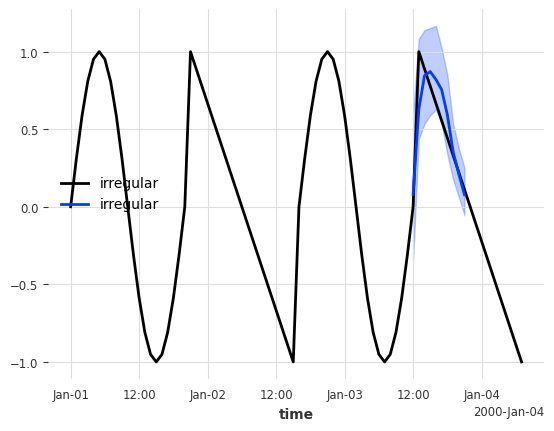

In [ ]:
sine_series_st_bin = sine_series.with_static_covariates(
    pd.DataFrame(data={'Curve_type': [1]}))
irregular_series_st_bin = irregular_series.with_static_covariates(
    pd.DataFrame(data={'Curve_type': [0]}))
train_series = [sine_series_st_bin, irregular_series_st_bin]
for series in train_series:
    print(series.static_covariates)

model = TFTModel(**get_model_params())
preds_st_bin = test_case(
    model,
    train_series,
    predict_series=[series[:60] for series in train_series])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | future_cov_projection | _ResidualBlock   | 780    | train
6 | encoders              | Sequential       | 40.1 K | train
7 | decoders              | Sequential       | 99.1 K | train
8 | temporal_decoder      | _ResidualBlock   | 1.3 K  | train
9 | lookback_skip       

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

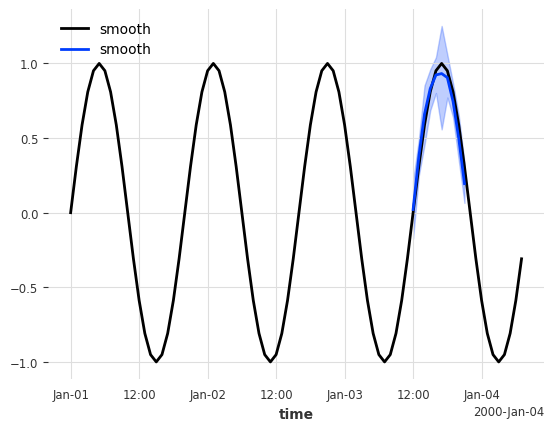

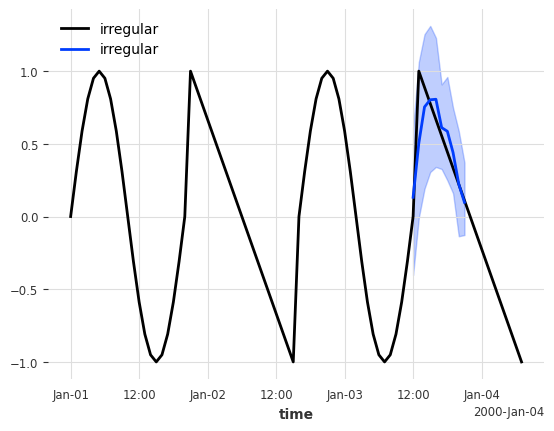

In [ ]:
model = TiDEModel(**get_model_params(), likelihood=GaussianLikelihood(),  # Corrected: Iikelihood -> likelihood
                 use_static_covariates=True)
preds = test_case(model, train_series,
    predict_series=[series[:60] for series in train_series]) # Corrected: series[':60'] -> series[:60]

In [ ]:
# Snippet 1: Preprocessing static covariates
sine_series_st_cat = sine_series.with_static_covariates(
    pd.DataFrame(data={"curve_type": ["smooth"]}))  # Fixed DataFrame syntax
irregular_series_st_cat = irregular_series.with_static_covariates(
    pd.DataFrame(data={"curve_type": ["non_smooth"]}))  # Fixed DataFrame syntax
train_series = [sine_series_st_cat, irregular_series_st_cat]
scaler = StaticCovariatesTransformer()
train_series = scaler.fit_transform(train_series)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 4      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 48     | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.2 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

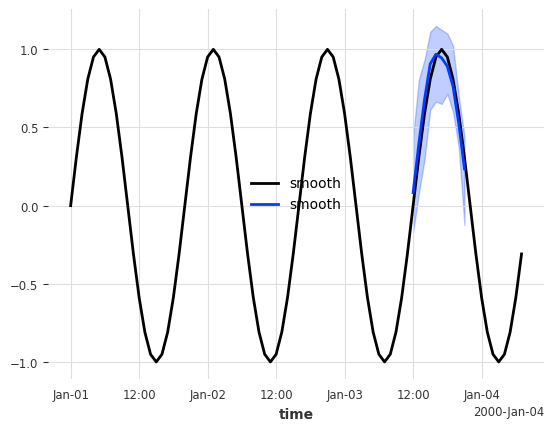

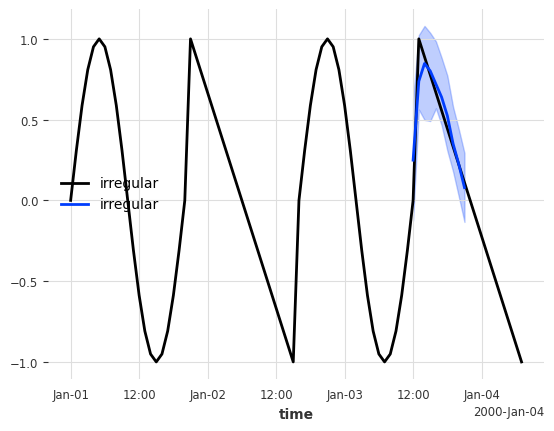

In [ ]:
# Snippet 2: TFTModel with embeddings
n_categories = 2
embedding_size = 2
categorical_embedding_sizes = {'curve_type': (n_categories, embedding_size)}
model = TFTModel(
    categorical_embedding_sizes=categorical_embedding_sizes,
    **get_model_params()
)

# Pass the MODEL and TRAINING DATA to test_case()
preds_st_cat = test_case(
    model,  # Pass the model itself, not model.train_series
    train_series,  # Explicitly provide the training data
    predict_series=[series[:60] for series in train_series]
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | MSELoss          | 0      | train
1 | train_criterion       | MSELoss          | 0      | train
2 | val_criterion         | MSELoss          | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | future_cov_projection | _ResidualBlock   | 780    | train
6 | encoders              | Sequential       | 40.1 K | train
7 | decoders              | Sequential       | 99.1 K | train
8 | temporal_decoder      | _ResidualBlock   | 1.3 K  | train
9 | lookback_skip       

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

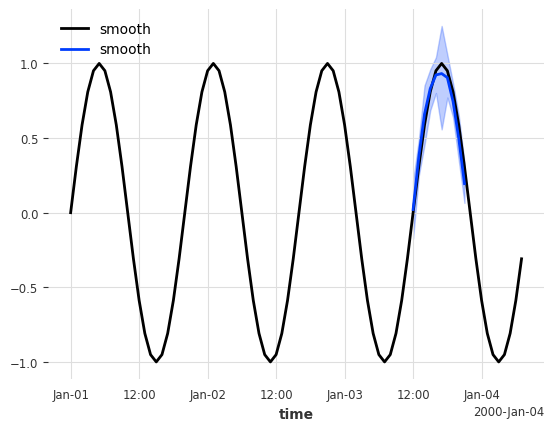

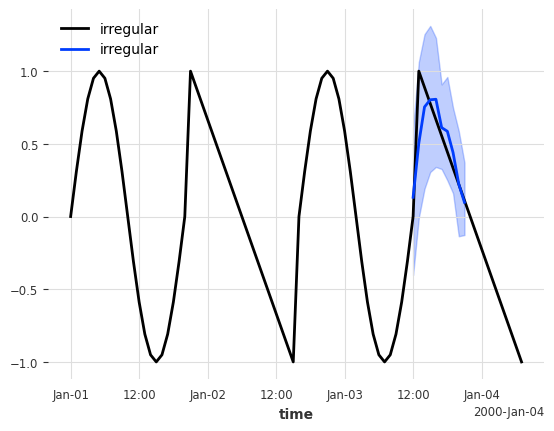

In [ ]:
# Snippet 3: TIDEModel with Gaussian likelihood
model = TiDEModel(  # Removed invalid **
    **get_model_params(),
    likelihood=GaussianLikelihood()  # Corrected parameter name and value
)
preds = test_case(
    model,
    train_series,
    predict_series=[series[:60] for series in train_series]  # Fixed slicing syntax
)

# TFT의 설명 가능성(p374~)

In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.3/963.3 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 45.3 MB/s eta 0:00:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf  # Fixed typo
from darts.datasets import IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries  # Fixed import

# Load dataset
series_ice_heater = IceCreamHeaterDataset().load()

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
converted_series = []
for col in ['ice cream', 'heater']:
  converted_series.append(series_ice_heater[col]
   / TimeSeries.from_series(series_ice_heater.time_index.days_in_month))

# Concatenate the series
converted_series = concatenate(converted_series, axis=1)  # Use Darts method
converted_series = converted_series[pd.Timestamp('2010-01-01'):]  # Fixed slicing syntax

# Prepare forecast horizon
forecast_horizon_ice = 12
training_cutoff_ice = converted_series.time_index[-(2 * forecast_horizon_ice)]  # Fixed indexing

# Split and scale the target series
series_ice = converted_series['ice cream']
train_ice, val_ice = series_ice.split_before(training_cutoff_ice)  # Fixed variable names
transformer_ice = Scaler()  # Correct Scaler class
train_ice_transformed = transformer_ice.fit_transform(train_ice)
val_ice_transformed = transformer_ice.transform(val_ice)
series_ice_transformed = transformer_ice.transform(series_ice)

# Process covariates (heater)
covariates_heat = converted_series['heater']
cov_heat_train, cov_heat_val = covariates_heat.split_before(training_cutoff_ice)  # Fixed variable names
transformer_heat = Scaler()  # Correct Scaler class
transformer_heat.fit(cov_heat_train)
covariates_heat_transformed = transformer_heat.transform(covariates_heat)

In [ ]:
input_chunk_length_ice = 38

# Initialize TFTModel with corrected parameters
my_model_ice = TFTModel(  # Fixed TFTMode → TFTModel
    input_chunk_length=input_chunk_length_ice,
    output_chunk_length=forecast_horizon_ice,
    hidden_size=32,
    lstm_layers=1,
    batch_size=16,
    n_epochs=300,  # Fixed typo: n_epoche → n_epochs
    dropout=0.1,
    add_encoders={'cyclic': {'future': ['month']}},  # Fixed dictionary syntax
    add_relative_index=False,  # Fixed typo: add_rightive_index
    optimizer_kwargs={'lr': 1e-3},  # Corrected optimizer args (lr instead of n)
    random_state=42
)

# Train the model
my_model_ice.fit(  # Fixed method name: hit → fit
    series=train_ice_transformed,
    past_covariates=covariates_heat_transformed,
    verbose=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 3.9 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


TFTModel(output_chunk_shift=0, hidden_size=32, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=38, output_chunk_length=12, batch_size=16, n_epochs=300, add_encoders={'cyclic': {'future': ['month']}}, optimizer_kwargs={'lr': 0.001}, random_state=42)

In [ ]:
from darts.explainability import TFTExplainer  # Import correct class

# Initialize explainer
explainer = TFTExplainer(my_model_ice)  # Fixed class name: TFTExplaner → TFTExplainer

# Generate explanations
explainability_result = explainer.explain()  # Fixed method name: explan → explain

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

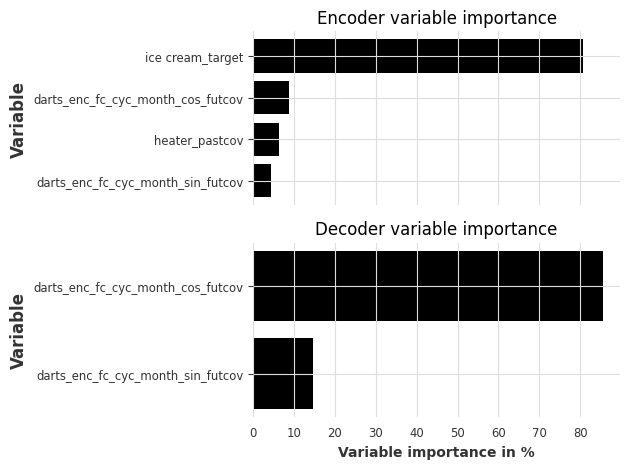

In [ ]:
explainer.plot_variable_selection(explainability_result)

In [ ]:
explainability_result.get_encoder_importance()

,darts_enc_fc_cyc_month_sin_futcov,heater_pastcov,darts_enc_fc_cyc_month_cos_futcov,ice cream_target
0,4.3,6.3,8.8,80.6


In [ ]:
explainability_result.get_decoder_importance()

,darts_enc_fc_cyc_month_sin_futcov,darts_enc_fc_cyc_month_cos_futcov
0,14.5,85.5


In [ ]:
explainability_result.get_static_covariates_importance()

""


In [ ]:
attentions = explainability_result.get_attention()
print(attentions.pd_dataframe().shape)

(50, 12)


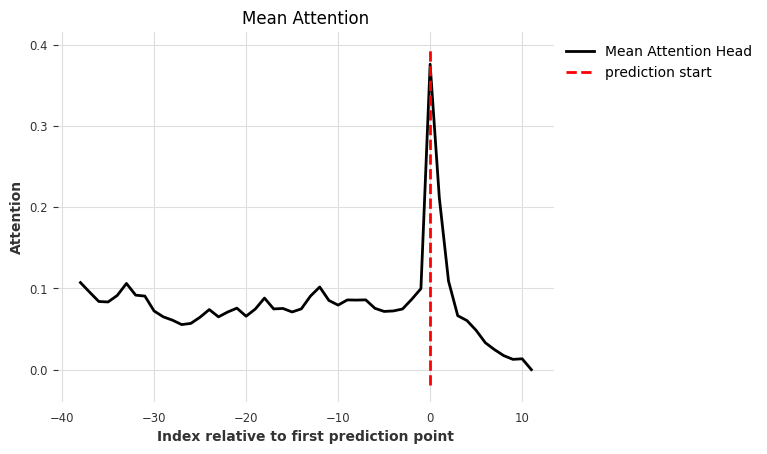

<Axes: title={'center': 'Mean Attention'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [ ]:
explainer.plot_attention(explainability_result, plot_type='time')

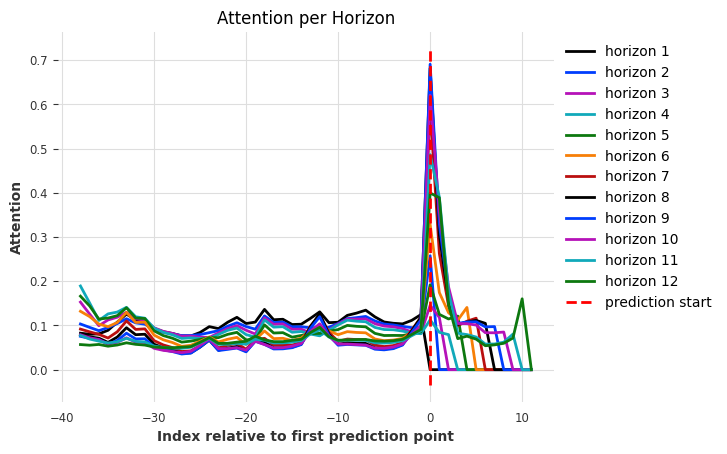

<Axes: title={'center': 'Attention per Horizon'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [ ]:
explainer.plot_attention(explainability_result, plot_type='all')

In [ ]:
# Add static covariates with proper DataFrame syntax
series_ice = converted_series['ice cream']
series_ice = series_ice.with_static_covariates(pd.DataFrame(data={'item': ['ice']}))  # Fixed quotes
scaler_ice = Scaler()
ice_tr = scaler_ice.fit_transform(series_ice)

series_heat = converted_series['heater']
series_heat = series_heat.with_static_covariates(pd.DataFrame(data={'item': ['heater']}))  # Fixed quotes
scaler_heat = Scaler()
heat_tr = scaler_heat.fit_transform(series_heat)

series_train = [ice_tr, heat_tr]

from darts.dataprocessing.transformers import StaticCovariatesTransformer
scaler = StaticCovariatesTransformer()
train_series = scaler.fit_transform(series_train)

# Split training and validation sets
train_ice, val_ice = train_series[0].split_before(training_cutoff_ice)
train_heat, val_heat = train_series[1].split_before(training_cutoff_ice)

In [ ]:
input_chunk_length = 36
forecast_horizon = 12
embedding_size = 32
embedding_sizes = {"item": (2, embedding_size)}  # Embedding for 2 categories: ice/heater

model_multi = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=32,
    categorical_embedding_sizes=embedding_sizes,
    lstm_layers=1,
    batch_size=16,
    n_epochs=300,
    dropout=0.1,
    add_encoders={"cyclic": {'future': ['month']}},  # Fixed closing brace
    add_relative_index=False,
    optimizer_kwargs={'lr': 1e-3},  # Corrected parameter: 'lr' instead of 'h'
    random_state=42
)

# Train the model
model_multi.fit(
    series=train_ice,
    past_covariates=train_heat,
    verbose=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 64     | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 96     | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 3.9 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


TFTModel(output_chunk_shift=0, hidden_size=32, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes={'item': (2, 32)}, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=36, output_chunk_length=12, batch_size=16, n_epochs=300, add_encoders={'cyclic': {'future': ['month']}}, optimizer_kwargs={'lr': 0.001}, random_state=42)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 1039.89%


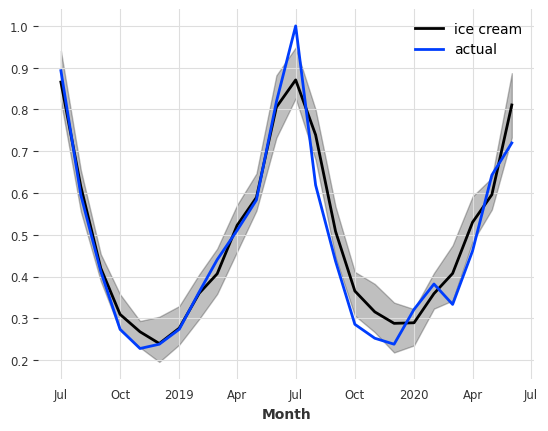

In [ ]:
# Predict ice cream sales
# Ensure covariates_heat_transformed covers the prediction horizon
pred = model_multi.predict(n=24, series=train_ice, past_covariates=covariates_heat_transformed, num_samples=200)
pred.plot()
val_ice.plot(label="actual")
print("MAPE: {:.2%}".format(mape(val_ice, pred)))  # Fixed formatting

# p383~

In [ ]:
# Predict ice cream sales
# Ensure covariates cover the prediction horizon by adjusting
# the split or providing a longer covariate series.
# Example: If train_heat ends before the required timestamp,
# consider using a different split for train_heat or extend
# it with additional data.

# Assuming covariates_heat_transformed is the proper length
pred = model_multi.predict(
    n=24,
    series=train_ice,
    future_covariates=covariates_heat_transformed[-len(train_ice)-24:],  # Ensure sufficient future data
    num_samples=200
)

pred.plot()
val_ice.plot(label="actual")
print("MAPE: {:.2%}".format(mape(val_ice, pred)))

ERROR:darts.utils.data.inference_dataset:ValueError: For the given forecasting horizon `n=24`, the provided past covariates at dataset index `0` do not extend far enough into the future. As `n > output_chunk_length` the past covariates must end at time step `2019-06-01 00:00:00`, whereas now they end at time step `2018-06-01 00:00:00`.


ValueError: For the given forecasting horizon `n=24`, the provided past covariates at dataset index `0` do not extend far enough into the future. As `n > output_chunk_length` the past covariates must end at time step `2019-06-01 00:00:00`, whereas now they end at time step `2018-06-01 00:00:00`.

In [ ]:
from darts.explainability import TFTExplainer

# Initialize explainer with correct model and data
explainer_ice = TFTExplainer(
    model=model_multi,  # Fixed variable name: model_mull → model_multi
    background_series=train_ice
)

# Generate explanations
explainability_result_ice = explainer_ice.explain()
explainer_ice.plot_variable_selection(explainability_result_ice)

ERROR:darts.explainability.utils:ValueError: A background past covariates is not provided, but the model requires past covariates.


ValueError: A background past covariates is not provided, but the model requires past covariates.